# Keras: Time Series Anomaly
***

This Jupyter notebook will contain a clear and concise overview of how to load CAO points information from the CAO website into a pandas data frame, a detailed comparison of the level 8 CAO points in 2019, 2020, and 2021 and some visualisations to enhance the viewer experience.

<br>

# From Ian's Notebook

***

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

## Evaluation
***

In [1]:
# Numerical arrays
import numpy as np

# Spreadsheet-like Data Frames
import pandas as pd

# Neural networks
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt

<br>

## Data
***

https://www.kaggle.com/datasets/boltzmannbrain/nab

https://github.com/numenta/NAB

In this section I gather the data for my project, import the data into dataframes, check that the data looks OK and do an inital plot of the data so we can take a look at what we're working with.

In [2]:
# Root of URLs
root_url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/'

# Data file without anomaly
no_anomaly_url = root_url + 'artificialNoAnomaly/art_daily_small_noise.csv'

# Data file with anomaly
with_anomaly_url = root_url + 'artificialWithAnomaly/art_daily_jumpsup.csv'

In [3]:
# Checking the no anomaly URL looks OK
no_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialNoAnomaly/art_daily_small_noise.csv'

In [4]:
# Checking the with anomaly URL looks OK
with_anomaly_url

'https://raw.githubusercontent.com/numenta/NAB/master/data/artificialWithAnomaly/art_daily_jumpsup.csv'

In [5]:
# Reading the no anomaly data into a data frame called small noise
df_small_noise = pd.read_csv(no_anomaly_url, parse_dates=True, index_col="timestamp")

In [6]:
# Taking a look at the top 5 values in the data frame
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [7]:
# Using describe to check how many lines are in the data & see some basic stats
df_small_noise.describe()

,value
count,4032.000000
mean,42.438353
std,28.077122
min,18.000964
25%,19.841390
50%,21.608487
75%,75.450282
max,87.976128


In [8]:
# Taking a look at the first value in the data frame
#df_small_noise.iloc[0]
#df_small_noise.iloc[0].values[0]
df_small_noise.iloc[0]['value']

18.3249185392

In [9]:
# Use shape method to see how many values are in the data frame
df_small_noise.shape

(4032, 1)

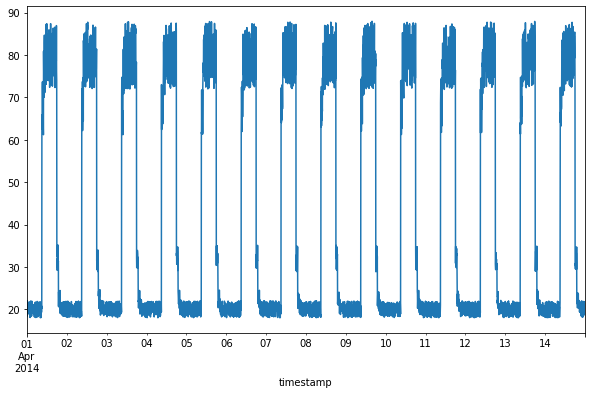

In [10]:
# Creating a subplot
fig, ax = plt.subplots(figsize=(10,6))

# Use pandas to plot the data frame
df_small_noise.plot(legend=False, ax=ax);

In [11]:
# Reading the with anomaly data into a data frame called daily jumpsup
df_daily_jumpsup = pd.read_csv(with_anomaly_url, parse_dates=True, index_col="timestamp")

In [12]:
# Have a look at the top 5 values
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


In [13]:
# Using the describe method to see the no. of values & other basic stats of the date frame
df_daily_jumpsup.describe()

#df_daily_jumpsup.shape

,value
count,4032.000000
mean,44.494254
std,32.432473
min,18.001010
25%,19.991382
50%,21.648503
75%,76.435943
max,164.947481


In [14]:
# Checking the first value in the second data frame
df_daily_jumpsup.iloc[0]['value']

19.761251903

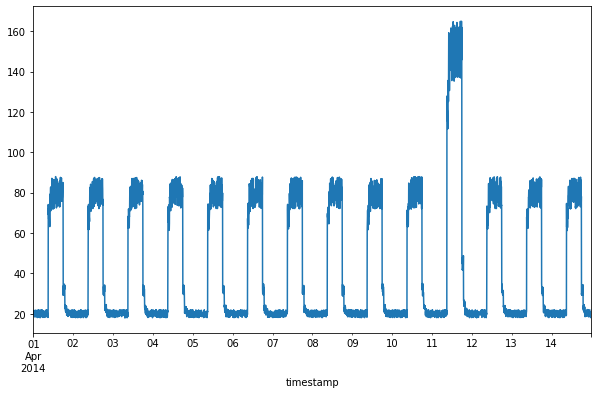

In [68]:
# Creating another subplot
fig, ax = plt.subplots(figsize=(10,6))

# Use pandas to plot the second data frame
df_daily_jumpsup.plot(legend=False, ax=ax);

<br>

## Pre-Processing
***

In [17]:
# 
train_mean = df_small_noise.mean()

train_mean

value    42.438353
dtype: float64

In [18]:
# 
train_std = df_small_noise.std()

train_std

value    28.077122
dtype: float64

In [19]:
# 
df_train_vals = (df_small_noise - train_mean) / train_std

In [20]:
# 
df_train_vals.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


In [21]:
# 
df_small_noise['less_mean'] = df_small_noise['value'] - df_small_noise['value'].mean()
df_small_noise['div_std'] = df_small_noise['less_mean'] / df_small_noise['value'].std()

In [22]:
df_small_noise

,value,less_mean,div_std
timestamp,,,
2014-04-01 00:00:00,18.324919,-24.113435,-0.858829
2014-04-01 00:05:00,21.970327,-20.468026,-0.728993
2014-04-01 00:10:00,18.624806,-23.813547,-0.848148
2014-04-01 00:15:00,21.953684,-20.484669,-0.729586
2014-04-01 00:20:00,21.909120,-20.529234,-0.731173
...,...,...,...
2014-04-14 23:35:00,20.211195,-22.227159,-0.791647
2014-04-14 23:40:00,20.531041,-21.907313,-0.780255
2014-04-14 23:45:00,19.032127,-23.406226,-0.833640


In [23]:
df_small_noise['value'].mean(), df_small_noise['less_mean'].mean(), df_small_noise['div_std'].mean()

(42.438353335806646, -7.342627387941552e-14, -2.616541242931684e-15)

In [24]:
df_small_noise['value'].std(), df_small_noise['less_mean'].std(), df_small_noise['div_std'].std()

(28.077122281262515, 28.077122281262508, 1.0000000000000018)

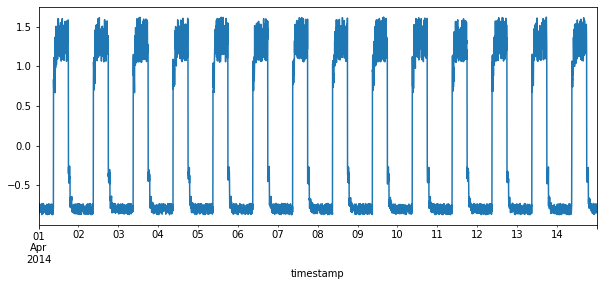

In [25]:
# 
fig, ax = plt.subplots(figsize=(10,4))

# Use pandas to plot data frame.
df_train_vals.plot(legend=False, ax=ax);

In [26]:
# 
df_train_vals.shape

(4032, 1)

In [27]:
# 
window_size = 288

Window example:

```python
[1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
window_size = 3
[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
...
```

In [28]:
# Window list example.
L = [1, 1, 2, 4, 5, 6, 7, 1, 2, 3, 4, 5]
# Example window size.
win_size = 3
# Length of L.
len(L)

12

In [29]:
# Number of windows from L.
len(L) - (win_size - 1)

10

In [30]:
# Remove brackets.
len(L) - win_size + 1

10

In [31]:
# Print the windows.
for i in range(len(L) - win_size + 1):
    print(L[i:i + win_size])

[1, 1, 2]
[1, 2, 4]
[2, 4, 5]
[4, 5, 6]
[5, 6, 7]
[6, 7, 1]
[7, 1, 2]
[1, 2, 3]
[2, 3, 4]
[3, 4, 5]


In [32]:
# For accumulating the windows.
wins = []

# Generate the windows
for i in range(len(L) - win_size + 1):
    wins.append(L[i:i + win_size])

wins

[[1, 1, 2],
 [1, 2, 4],
 [2, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 1],
 [7, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5]]

In [33]:
# Create a 2D numpy array from wins.
np.stack(wins)

array([[1, 1, 2],
       [1, 2, 4],
       [2, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 1],
       [7, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

In [34]:
# 
def windows(vals, N=window_size):
  # 
  L = []
  # 
  for i in range(len(vals) - N + 1):
    # 
    L.append(vals[i:i+N])
  # Stack
  return np.stack(L)

In [35]:
# 
x_train = windows(df_train_vals)

In [36]:
# 
x_train[0][0], x_train[-1][-1]

(array([-0.85882857]), array([-0.8460886]))

In [37]:
# 
df_train_vals.iloc[0], df_train_vals.iloc[-1]

(value   -0.858829
 Name: 2014-04-01 00:00:00, dtype: float64,
 value   -0.846089
 Name: 2014-04-14 23:55:00, dtype: float64)

In [38]:
# 
x_train.shape

(3745, 288, 1)

In [39]:
#
df_train_vals['value'].values

array([-0.85882857, -0.72899302, -0.84814772, ..., -0.83364049,
       -0.73510213, -0.8460886 ])

In [40]:
# 
x_train[0].flatten()

array([-0.85882857, -0.72899302, -0.84814772, -0.72958579, -0.731173  ,
       -0.75730984, -0.77645641, -0.7880838 , -0.747012  , -0.829166  ,
       -0.80377285, -0.7821597 , -0.81182078, -0.80949918, -0.82334701,
       -0.79001779, -0.74922405, -0.84169024, -0.73727717, -0.77223023,
       -0.75311352, -0.79116337, -0.75934728, -0.86809294, -0.75381057,
       -0.86468256, -0.74361965, -0.72908121, -0.82850668, -0.84043795,
       -0.76136364, -0.8343536 , -0.74708881, -0.85574949, -0.85245676,
       -0.73090636, -0.77440264, -0.74974936, -0.82419543, -0.77402585,
       -0.78574242, -0.7844733 , -0.77316412, -0.78843253, -0.80927467,
       -0.83109167, -0.76090519, -0.83816509, -0.77176485, -0.83715923,
       -0.78131343, -0.76396862, -0.83924191, -0.86186112, -0.85174179,
       -0.78406773, -0.74938477, -0.86399047, -0.76581026, -0.82177506,
       -0.80222751, -0.73807119, -0.82310669, -0.80410682, -0.86845167,
       -0.85877599, -0.83356075, -0.86643297, -0.78045221, -0.80

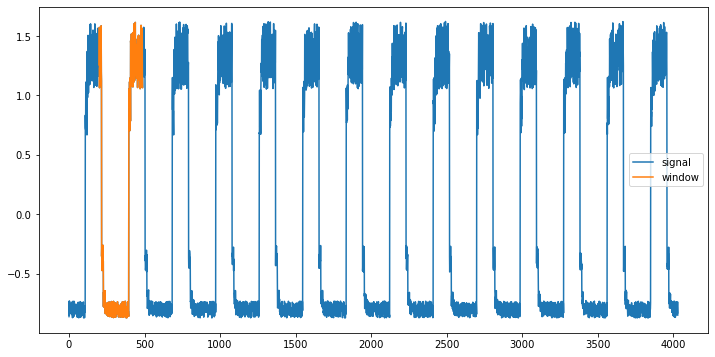

In [41]:
# 
window_no = 200

# 
fig, ax = plt.subplots(figsize=(12, 6))

# 
y = df_train_vals['value'].values

# 
ax.plot(np.arange(y.shape[0]), y, label='signal')

# The first window.
w = x_train[window_no].flatten()

# 
ax.plot(np.arange(w.shape[0]) + window_no, w, label='window')

ax.legend();

<br>

## Neural Network
***

In [42]:
x_train.shape

(3745, 288, 1)

In [43]:
#
layers = [
  #
  keras.layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
  #
  keras.layers.Conv1D(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1D(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(
    filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Dropout(rate=0.2),
  #
  keras.layers.Conv1DTranspose(
    filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
  #
  keras.layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
]

In [44]:
#
model = keras.Sequential(layers)

In [45]:
# 
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [46]:
# 
model.compile(optimizer=optimizer, loss="mse")

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

In [48]:
# 
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 3s 61ms/step - loss: 0.5897 - val_loss: 0.2146
Epoch 2/50
27/27 [==============================] - 1s 47ms/step - loss: 0.1002 - val_loss: 0.0496
Epoch 3/50
27/27 [==============================] - 1s 45ms/step - loss: 0.0596 - val_loss: 0.0377
Epoch 4/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0496 - val_loss: 0.0314
Epoch 5/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0428 - val_loss: 0.0273
Epoch 6/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0375 - val_loss: 0.0237
Epoch 7/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0334 - val_loss: 0.0220
Epoch 8/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0302 - val_loss: 0.0204
Epoch 9/50
27/27 [==============================] - 1s 44ms/step - loss: 0.0278 - val_loss: 0.0169
Epoch 10/50
27/27 [==============================] - 1s 43ms/step - loss: 0.0257 - val_loss: 0.0178
Epoch 11/

<br>

## Evaluation
***

In [49]:
history.history["loss"]

[0.5897437334060669,
 0.10023283213376999,
 0.059550028294324875,
 0.04956883564591408,
 0.042808011174201965,
 0.0375443696975708,
 0.033438391983509064,
 0.030179761350154877,
 0.027755387127399445,
 0.025730488821864128,
 0.024007750675082207,
 0.022571373730897903,
 0.021297726780176163,
 0.02018633671104908,
 0.01915372535586357,
 0.018118135631084442,
 0.01738097332417965,
 0.01663573458790779,
 0.015841789543628693,
 0.015256986953318119,
 0.014724337495863438,
 0.014019615016877651,
 0.013312803581357002,
 0.012737887911498547,
 0.012186096049845219,
 0.011588597670197487]

In [50]:
history.history["val_loss"]

[0.2146066278219223,
 0.04959138110280037,
 0.03766145929694176,
 0.03141035512089729,
 0.027329104021191597,
 0.023709602653980255,
 0.021977556869387627,
 0.020397840067744255,
 0.01691964641213417,
 0.01779777742922306,
 0.017415178939700127,
 0.015251473523676395,
 0.015227429568767548,
 0.01544447336345911,
 0.0159921795129776,
 0.014006092213094234,
 0.016002850607037544,
 0.01429530419409275,
 0.014407407492399216,
 0.01524854265153408,
 0.012067512609064579,
 0.014397582970559597,
 0.01434344332665205,
 0.015608083456754684,
 0.01254770252853632,
 0.013467037118971348]

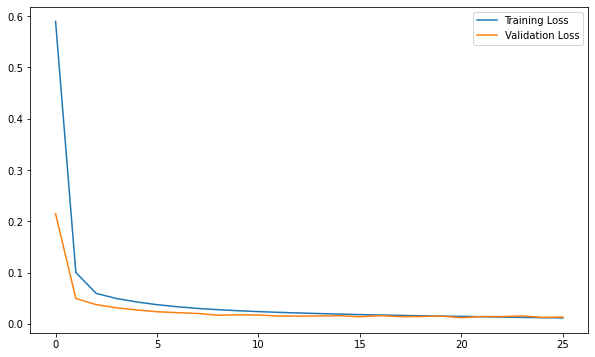

In [51]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.plot(history.history["loss"], label="Training Loss")
# 
ax.plot(history.history["val_loss"], label="Validation Loss")
# 
ax.legend();

In [52]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)

118/118 [==============================] - 1s 5ms/step


In [53]:
# Calculate loss...
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

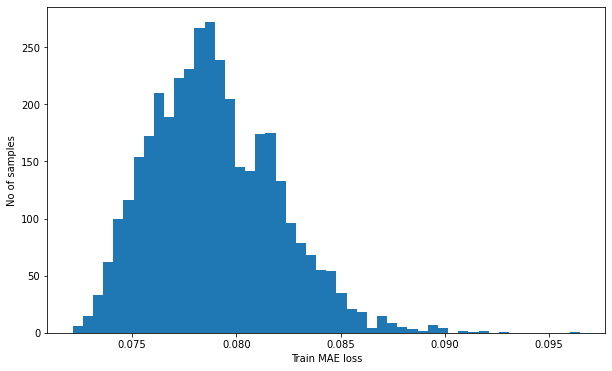

In [54]:
# 
fig, ax = plt.subplots(figsize=(10, 6))
# 
ax.hist(train_mae_loss, bins=50)
# 
ax.set_xlabel("Train MAE loss")
#
ax.set_ylabel("No of samples");

In [55]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)

# 
threshold

0.09648891150063497

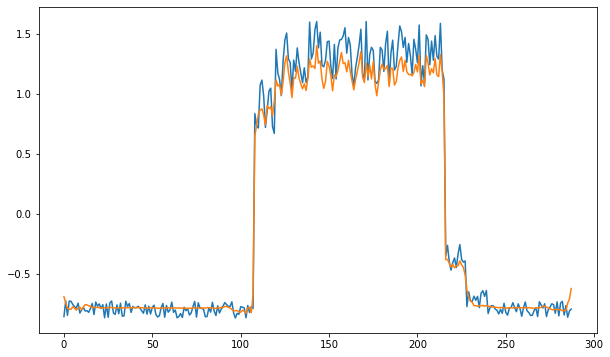

In [56]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
ax.plot(x_train[0])

# 
ax.plot(x_train_pred[0]);

In [57]:
# 
df_test_value = (df_daily_jumpsup - train_mean) / train_std

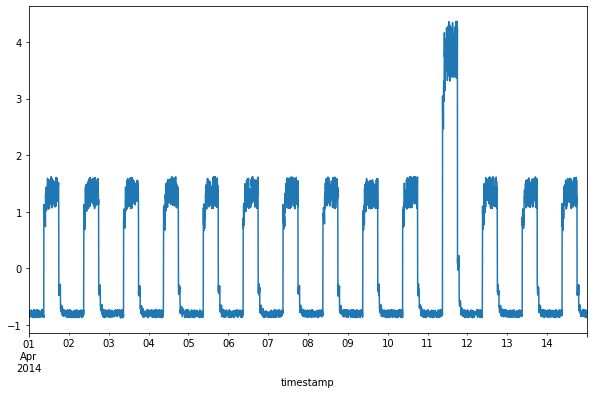

In [58]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_test_value.plot(legend=False, ax=ax);

In [59]:
# Create sequences from test values.
x_test = windows(df_test_value.values)

x_test.shape

(3745, 288, 1)

In [60]:
# 
x_test_pred = model.predict(x_test)

118/118 [==============================] - 1s 6ms/step


In [61]:
# 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

test_mae_loss

array([[0.07648065],
       [0.07531652],
       [0.07676795],
       ...,
       [0.08247914],
       [0.08123135],
       [0.08013653]])

In [62]:
# 
test_mae_loss = test_mae_loss.reshape((-1))

test_mae_loss

array([0.07648065, 0.07531652, 0.07676795, ..., 0.08247914, 0.08123135,
       0.08013653])

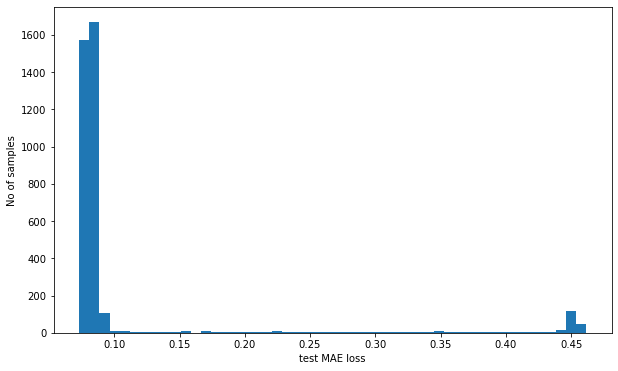

In [63]:
# 
fig, ax = plt.subplots(figsize=(10, 6))

#
ax.hist(test_mae_loss, bins=50)

# 
ax.set_xlabel("test MAE loss")

# 
ax.set_ylabel("No of samples");

In [64]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold

# NUmber of anomalies.
np.sum(anomalies)

395

In [65]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
inds = []

for i in range(window_size - 1, len(df_test_value) - window_size + 1):
    if np.all(anomalies[i - window_size + 1 : i]):
        inds.append(i)

In [66]:
# 
df_subset = df_daily_jumpsup.iloc[inds]

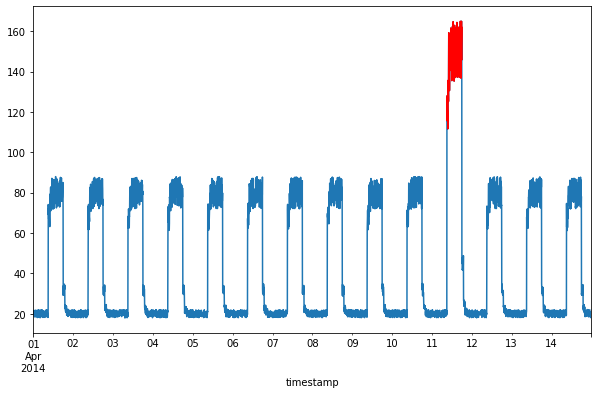

In [67]:
#
fig, ax = plt.subplots(figsize=(10, 6))

# 
df_daily_jumpsup.plot(legend=False, ax=ax)

# 
df_subset.plot(legend=False, ax=ax, color="r");

<br>

## Conclusion
***

In conclusion....

<br>

# End
***